In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.impute import SimpleImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

from scipy.stats import pearsonr

sys.path.append("../")

import utils_ML as uml
import AtlasAnalysisFunctions as AAF

In [2]:
data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [3]:
filtering = uml.FilterByOccurence(.5)
exp_prep_data = filtering.fit_transform(np.exp2(data), targets)
exp_prep_data = pd.DataFrame(exp_prep_data, columns = filtering.filtered_proteins)

In [4]:
correlation_matrix = exp_prep_data.corr(method="pearson", min_periods=100)

In [12]:
cor_list = correlation_matrix.reset_index().melt(id_vars='index')

In [18]:
cor_list = cor_list.replace(to_replace=1.0, value=np.nan).dropna()

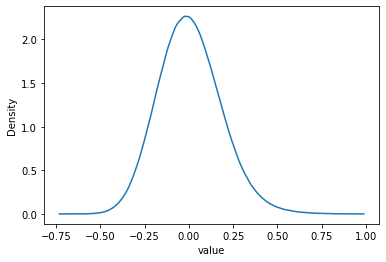

In [20]:
sns.kdeplot(cor_list.value)

In [54]:
na_cols = correlation_matrix.isna().sum() == 1

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1080x1080 with 0 Axes>

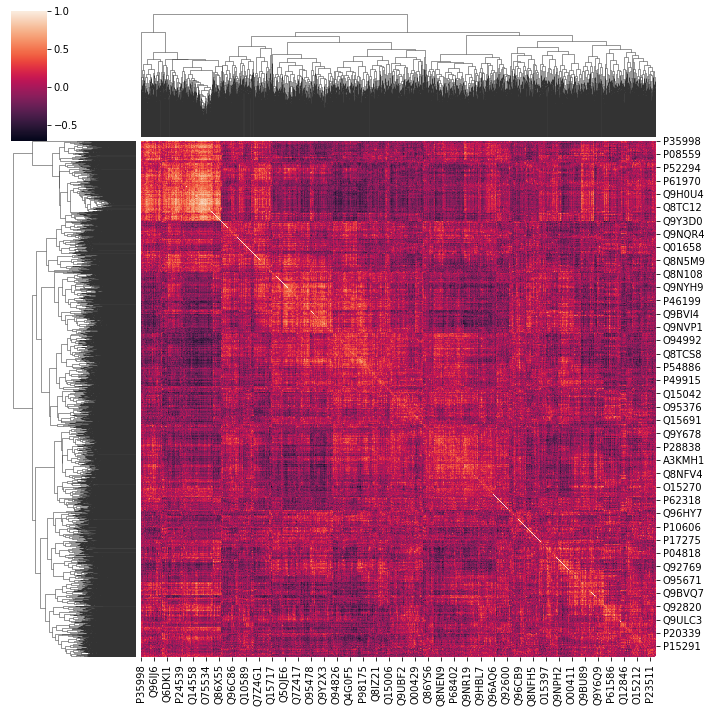

In [55]:
plt.figure(figsize=(15,15))
sns.clustermap(data=correlation_matrix.loc[~na_cols, ~na_cols])

In [77]:
cor_list["index"].nunique()

2615

In [74]:
for x in cor_list[(cor_list.value < .2) & (cor_list.value > .19)]["index"].unique():
    print(x)

O75351
O75874
O95674
P02792
P11274
P22307
P41240
P60953
Q02952
Q13228
Q13907
Q66K74
Q86X76
Q8N0X7
Q8NBS9
Q96AJ9
Q96C19
Q96K76
Q99832
Q9BST9
Q9H3Z4
Q9H444
Q9HD20
Q9NRY4
Q9NX62
Q9P253
Q9UKA4
Q9Y3D6
Q9Y3I1
A3KMH1
O00767
O15111
O15270
O95456
O95613
P05141
P07099
P08243
P10398
P10606
P14209
P36542
P49207
P53999
P56385
P62140
P82663
Q04941
Q06323
Q13131
Q15054
Q15527
Q5W111
Q6DD87
Q6P4Q7
Q7LBR1
Q7RTV0
Q8IX04
Q8IX90
Q8WTT2
Q8WVC0
Q96GX2
Q96IX5
Q96SI9
Q99797
Q9H3N1
Q9NQZ2
Q9NXG2
Q9NXV6
Q9UHR4
Q9Y692
O75394
O95470
P08047
P27105
Q3ZAQ7
Q712K3
Q7Z4G1
Q8NBX0
Q96A35
Q9BRP8
Q9BU76
Q9H490
Q9NR12
Q9Y679
O00425
O15460
O60502
O75362
P11047
P11388
P47985
P55809
P61981
P62314
P78356
P82912
Q01469
Q15058
Q15388
Q16658
Q53HL2
Q7L7X3
Q7Z392
Q8IV08
Q9BZL6
Q9HB40
Q9HB90
Q9NZZ3
Q9UER7
Q9ULC3
O15355
O43707
O60884
O75381
O95302
P10644
P29218
P46100
P61160
P61254
Q03164
Q12769
Q13637
Q53EL6
Q5T447
Q6IN85
Q6R327
Q7L2J0
Q969V3
Q96BN8
Q9BRX8
Q9BYT8
Q9C0I1
Q9H7D0
Q9NRG9
Q9NTX5
Q9NUQ3
Q9P1U1
Q9UHD9
Q9UJV9
Q9ULR0
Q9ULW0

In [71]:
for x in cor_list[(cor_list.value > .8)]["index"].unique():
    print(x)

O14617
O15042
O43707
O60341
O75369
O75534
P04843
P12814
P12955
P14866
P16435
P23919
P26368
P27695
P41252
P42765
P49589
P51398
P53992
P62081
P62241
Q00839
Q01082
Q07960
Q12769
Q13813
Q14974
Q16891
Q1KMD3
Q86UE4
Q86XP3
Q8TAQ2
Q8TC12
Q8WWM7
Q96TA2
Q9BQG0
Q9H0A0
Q9H2U1
Q9H583
Q9UBT2
Q9Y265
Q9Y6G9
O14579
P49327
P78417
Q00325
Q5SSJ5
Q9UBM7
P38919
P49736
P61158
P34897
Q14697
P04406
P15121
Q01813
P30043
Q12907
Q16740
Q9GZT3
Q9HC35
P22695
P48047
P51812
O75439
Q12788
Q9BYG3
O60664
P12956
P18124
P20290
P54578
Q86VP6
P13489
P21266
P19623
P61978
Q15393
P25205
P13667
P06576
Q08211
Q13868
Q99643
Q3LXA3
Q9NP72
Q3ZAQ7
P78316
P36871
O43615


In [69]:
for x in cor_list[(cor_list.value > .8)][cor_list[(cor_list.value > .8)]["index"] == "O14579"].variable:
    print(x)

O14617
O15042
O43707
O60341
O75369
O75534
P04843
P12814
P12955
P14866
P16435
P23919
P26368
P27695
P41252
P42765
P49589
P51398
P53992
P62081
P62241
Q00839
Q01082
Q07960
Q12769
Q13813
Q14974
Q16891
Q1KMD3
Q86UE4
Q86XP3
Q8TAQ2
Q8TC12
Q8WWM7
Q96TA2
Q9BQG0
Q9H0A0
Q9H2U1
Q9H583
Q9UBT2
Q9Y265
Q9Y6G9


In [66]:
cor_list[(cor_list.value > .8)][cor_list[(cor_list.value > .8)]["index"] == "P12814"]

,index,variable,value
162588,P12814,O14579,0.871979
165203,P12814,O14617,0.811952
382248,P12814,O43707,0.833102
1522388,P12814,P26368,0.800256
1551153,P12814,P27695,0.823508
1836188,P12814,P41252,0.856499
2387953,P12814,P62241,0.852614
2604998,P12814,Q00839,0.834678
4019713,P12814,Q86XP3,0.807224
4370123,P12814,Q8TAQ2,0.814626


In [63]:
cor_list[(cor_list.value > .8)].groupby("index").nunique()

,index,variable,value
index,,,
O14579,1,42,42
O14617,1,26,26
O15042,1,30,30
O43615,1,1,1
O43707,1,6,6
...,...,...,...
Q9NP72,1,2,2
Q9UBM7,1,3,3
Q9UBT2,1,10,10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


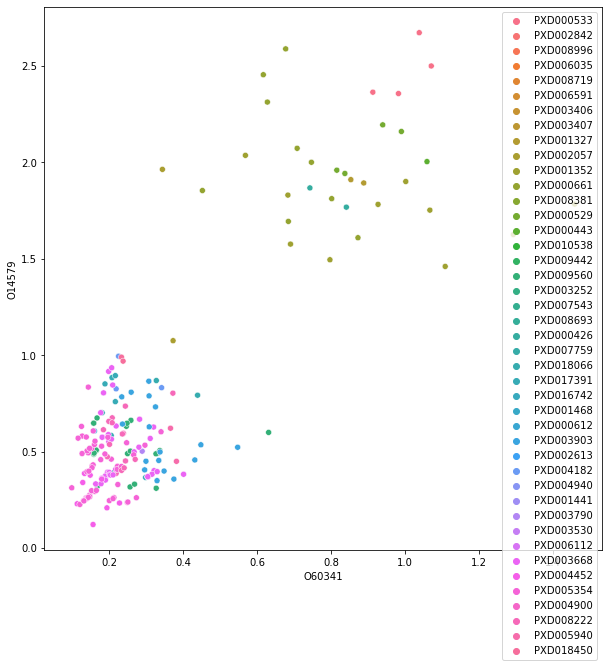

In [29]:
plt.figure(figsize=(10,10))
sns.scatterplot(exp_prep_data.loc[:, "O60341"], exp_prep_data.loc[:, "O14579"], hue=meta.PXD_accession.values)